In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from alphalens import utils
from alphalens import performance

In [3]:
trading_dates=get_trading_dates(datetime(2019,1,1),datetime(2019,12,31))
startDate=trading_dates[0]
endDate=trading_dates[-1]
stock_list=index_components('000300.XSHG')
factor_one_name='market_cap'
factor_two_name='basic_earnings_per_share'

In [4]:
q_one=query(fundamentals.eod_derivative_indicator.market_cap
           ).filter(fundamentals.eod_derivative_indicator.stockcode.in_(stock_list))
q_two=query(fundamentals.income_statement.basic_earnings_per_share
           ).filter(fundamentals.income_statement.stockcode.in_(stock_list))

In [5]:
#先处理因子1
df_facs_data_one=pd.DataFrame()
for i in range(len(trading_dates)):
    daily_fac_data=get_fundamentals(q_one,trading_dates[i],expect_df=True)
    daily_fac_data=daily_fac_data.reset_index()
    daily_fac_data['date']=trading_dates[i]
    daily_fac_data=daily_fac_data.set_index(['date','order_book_id'])
    df_facs_data_one=pd.concat([df_facs_data_one,daily_fac_data])

In [6]:
df_facs_data_one.head()

market_cap
date       order_book_id              
2019-01-02 000001.XSHE    1.577961e+11
           000002.XSHE    2.638357e+11
           000063.XSHE    8.200866e+10
           000069.XSHE    4.897837e+10
           000100.XSHE    3.400962e+10

In [7]:
def winsorize_series(series):
    q=series.quantile([0.02,0.98])
    if isinstance(q,pd.Series) and len(q)==2:
        series[series<q.iloc[0]]=q.iloc[0]
        series[series>q.iloc[1]]=q.iloc[1]
    return series

def standardize_series(series):
    std=series.std()
    mean=series.mean()
    return (series-mean)/std  

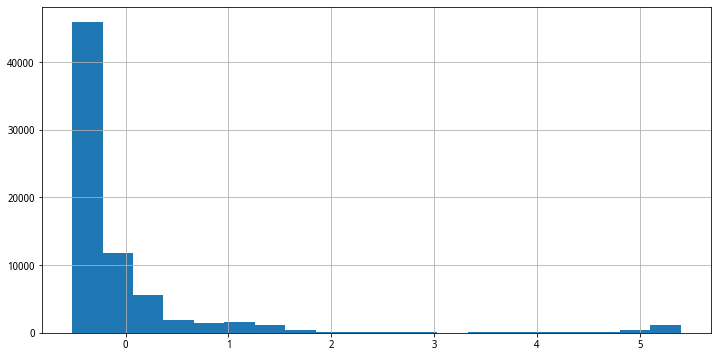

In [8]:
series_facs_data_one=df_facs_data_one['market_cap']
series_facs_data_one = series_facs_data_one.groupby(level = 'date').apply(winsorize_series)
series_facs_data_one = series_facs_data_one.groupby(level = 'date').apply(standardize_series)
series_facs_data_one.hist(figsize=(12,6),bins=20)
df_facs_data_one['market_cap']=series_facs_data_one

In [9]:
price=get_price(stock_list,start_date=startDate,end_date=endDate,fields='close')
price.head()

,600000.XSHG,600118.XSHG,601818.XSHG,600018.XSHG,600999.XSHG,601618.XSHG,601021.XSHG,002202.XSHE,000596.XSHE,002304.XSHE,...,002081.XSHE,600893.XSHG,601012.XSHG,601066.XSHG,601018.XSHG,600068.XSHG,601360.XSHG,600176.XSHG,600867.XSHG,600031.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,9.4076,17.9948,3.5038,5.0181,13.0964,2.9991,31.6472,8.6140,52.0927,88.6886,...,7.7403,21.3698,13.9971,8.6899,3.2550,6.1035,20.2569,9.2480,13.5770,7.8949
2019-01-03,9.5143,18.3033,3.5998,5.0768,13.2243,2.9991,31.1795,8.3286,50.1589,86.5371,...,7.7305,21.9861,14.0858,9.1155,3.2746,6.0647,19.9079,9.2383,12.2164,7.7772
2019-01-04,9.6598,18.3929,3.6862,5.1355,14.1000,3.0284,31.3884,8.7388,51.5106,87.9682,...,7.8382,22.1054,14.4564,10.0260,3.3334,6.1810,20.3667,9.3750,12.2952,7.9146
2019-01-07,9.6792,18.7811,3.6862,5.1550,13.9229,3.0382,31.4780,8.8993,51.6290,87.0239,...,7.8970,22.8111,14.8513,10.1052,3.3628,6.2682,20.7756,9.3750,12.8572,7.9832
2019-01-08,9.6598,18.2038,3.6670,5.1746,13.7851,2.9600,30.4530,9.1312,52.8030,88.4452,...,7.8284,22.4234,14.9077,10.5407,3.4217,6.2682,20.7157,9.2090,13.2714,7.9440


In [10]:
facs_data_one_analysis=utils.get_clean_factor_and_forward_returns(series_facs_data_one,price)

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [11]:
facs_data_one_analysis.head()

1D        5D       10D    factor  \
date       asset                                                 
2019-01-02 000001.XSHE  0.009790  0.081610  0.140362  0.494033   
           000002.XSHE  0.007115  0.059832  0.063601  1.257019   
           000063.XSHE -0.039877  0.018405  0.038344 -0.051279   
           000069.XSHE  0.001678  0.045231  0.033499 -0.288941   
           000100.XSHE  0.007982  0.123527  0.067739 -0.396646   

                        factor_quantile  
date       asset                         
2019-01-02 000001.XSHE                5  
           000002.XSHE                5  
           000063.XSHE                4  
           000069.XSHE                3  
           000100.XSHE                3

In [12]:
facs_data_one_analysis['factor']=np.float128(facs_data_one_analysis['factor'])

In [13]:
IC_data_one=performance.factor_information_coefficient(facs_data_one_analysis)

In [14]:
IC_data_one.head

<bound method NDFrame.head of                   1D        5D       10D
date                                    
2019-01-02  0.122726 -0.039608 -0.045315
2019-01-03 -0.198438 -0.148205 -0.082157
2019-01-04 -0.288498 -0.035520  0.007308
2019-01-07  0.035133  0.077170  0.056588
2019-01-08  0.230621  0.076907  0.036711
2019-01-09 -0.009763  0.019125 -0.000285
2019-01-10  0.014952  0.078578 -0.015180
2019-01-11 -0.095580  0.049318  0.035457
2019-01-14  0.022630  0.034104  0.081006
2019-01-15  0.068872 -0.009383  0.135143
2019-01-16  0.078668  0.014146  0.166413
2019-01-17  0.027984 -0.059904  0.197139
2019-01-18 -0.070010  0.039038  0.129604
2019-01-21 -0.060307  0.127985  0.073573
2019-01-22  0.087961  0.256742  0.046725
2019-01-23 -0.090237  0.285487  0.004940
2019-01-24  0.254024  0.362685  0.009089
2019-01-25  0.115329  0.239333 -0.217803
2019-01-28  0.340801  0.032241 -0.307170
2019-01-29  0.049985 -0.236445 -0.362266
2019-01-30  0.253503 -0.263665 -0.307042
2019-01-31 -0.392458 -0.392

In [15]:
IC_data_one_mean=IC_data_one.iloc[:,0].mean()
IC_data_one_std=IC_data_one.iloc[:,0].std()
IR_data_one=IC_data_one_mean/IC_data_one_std

In [16]:
IC_data_one_mean

0.0017288571400460417

In [17]:
IC_data_one_std

0.15525638883240742

In [18]:
freq_one=IC_data_one[IC_data_one.iloc[:,0]>0.02].iloc[:,0].count()/IC_data_one.iloc[:,0].count()
freq_one

0.44871794871794873

In [19]:
IR_data_one

0.011135497566623609

In [20]:
factor_one_return=performance.factor_returns(facs_data_one_analysis)
factor_one_return.head

<bound method NDFrame.head of                   1D        5D       10D
date                                    
2019-01-02  0.004586 -0.005407 -0.003403
2019-01-03 -0.006122 -0.009579 -0.006303
2019-01-04 -0.007433 -0.002068  0.001500
2019-01-07 -0.000254  0.003744  0.008856
2019-01-08  0.003849  0.004323  0.008345
2019-01-09  0.000299  0.001762  0.004635
2019-01-10  0.001388  0.003227  0.003952
2019-01-11 -0.001680  0.003561  0.008061
2019-01-14  0.000302  0.004962  0.010258
2019-01-15  0.001290  0.004084  0.017069
2019-01-16  0.001852  0.003153  0.017081
2019-01-17  0.001536 -0.001031  0.024552
2019-01-18 -0.000632  0.002620  0.012981
2019-01-21 -0.001139  0.003487  0.004571
2019-01-22 -0.000129  0.012115  0.000052
2019-01-23 -0.000943  0.013458 -0.002638
2019-01-24  0.005298  0.025832 -0.005012
2019-01-25  0.000566  0.010842 -0.016640
2019-01-28  0.007244  0.001098 -0.026421
2019-01-29  0.001356 -0.012400 -0.033552
2019-01-30  0.011525 -0.017377 -0.033372
2019-01-31 -0.010249 -0.032

In [21]:
mean_factor_one_return=factor_one_return.iloc[:,0].mean()
mean_factor_one_return

-0.00025365165946421607

In [22]:
#处理因子2
df_facs_data_two=pd.DataFrame()
for i in range(len(trading_dates)):
    daily_fac_data=get_fundamentals(q_two,trading_dates[i],expect_df=True)
    daily_fac_data=daily_fac_data.reset_index()
    daily_fac_data['date']=trading_dates[i]
    daily_fac_data=daily_fac_data.set_index(['date','order_book_id'])
    df_facs_data_two=pd.concat([df_facs_data_two,daily_fac_data])

In [23]:
df_facs_data_two.head()

basic_earnings_per_share
date       order_book_id                          
2019-01-02 000001.XSHE                      1.1400
           000002.XSHE                      1.2670
           000063.XSHE                     -1.7300
           000069.XSHE                      0.6205
           000100.XSHE                      0.1842

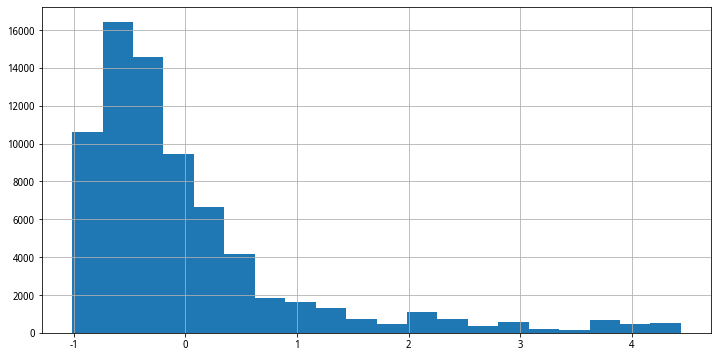

In [24]:
series_facs_data_two=df_facs_data_two['basic_earnings_per_share']
series_facs_data_two = series_facs_data_two.groupby(level = 'date').apply(winsorize_series)
series_facs_data_two = series_facs_data_two.groupby(level = 'date').apply(standardize_series)
series_facs_data_two.hist(figsize=(12,6),bins=20)
df_facs_data_two['basic_earnings_per_share']=series_facs_data_two

In [25]:
facs_data_two_analysis=utils.get_clean_factor_and_forward_returns(series_facs_data_two,price)

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [26]:
facs_data_two_analysis.head()

1D        5D       10D    factor  \
date       asset                                                 
2019-01-02 000001.XSHE  0.009790  0.081610  0.140362  0.541576   
           000002.XSHE  0.007115  0.059832  0.063601  0.713510   
           000063.XSHE -0.039877  0.018405  0.038344 -1.004197   
           000069.XSHE  0.001678  0.045231  0.033499 -0.161730   
           000100.XSHE  0.007982  0.123527  0.067739 -0.752399   

                        factor_quantile  
date       asset                         
2019-01-02 000001.XSHE                5  
           000002.XSHE                5  
           000063.XSHE                1  
           000069.XSHE                3  
           000100.XSHE                1

In [27]:
facs_data_two_analysis['factor']=np.float128(facs_data_two_analysis['factor'])

In [28]:
IC_data_two=performance.factor_information_coefficient(facs_data_two_analysis)

In [29]:
IC_data_two.head()

,1D,5D,10D
date,,,
2019-01-02,-0.398910,-0.261901,-0.106113
2019-01-03,-0.128514,-0.052349,0.090605
2019-01-04,-0.096266,0.108105,0.299426
2019-01-07,-0.046881,0.098248,0.422225
2019-01-08,0.379963,0.218264,0.450336


In [30]:
IC_data_two_mean=IC_data_two.iloc[:,0].mean()
IC_data_two_std=IC_data_two.iloc[:,0].std()

In [31]:
IC_data_two_mean

0.01637081231008546

In [32]:
IC_data_two_std

0.17717888847973556

In [33]:
freq_two=IC_data_two[IC_data_two.iloc[:,0]>0.02].iloc[:,0].count()/IC_data_two.iloc[:,0].count()
freq_two

0.47435897435897434

In [34]:
IR_data_two=IC_data_two_mean/IC_data_two_std
IR_data_two

0.09239708212729777

In [35]:
factor_two_return=performance.factor_returns(facs_data_two_analysis)
factor_two_return

,1D,5D,10D
date,,,
2019-01-02,-0.009235,-0.012346,-0.001390
2019-01-03,-0.006161,-0.000277,0.010504
2019-01-04,-0.003642,0.006256,0.023124
2019-01-07,-0.000569,0.005743,0.030701
2019-01-08,0.007967,0.015229,0.028518
2019-01-09,0.001832,0.010383,0.023239
2019-01-10,0.000498,0.010209,0.020436
2019-01-11,-0.004023,0.016244,0.025968
2019-01-14,0.008773,0.024672,0.031074


In [36]:
mean_factor_two_return=factor_two_return.iloc[:,0].mean()
mean_factor_two_return

0.00017349330550298683

In [37]:
#选取前百分之二十的股票
df_facs_data_two=df_facs_data_two.reset_index()
df_facs_data_two.head()

,date,order_book_id,basic_earnings_per_share
0,2019-01-02,000001.XSHE,0.541576
1,2019-01-02,000002.XSHE,0.713510
2,2019-01-02,000063.XSHE,-1.004197
3,2019-01-02,000069.XSHE,-0.161730
4,2019-01-02,000100.XSHE,-0.752399


In [38]:
df_facs_data_two_mean_eps=df_facs_data_two.groupby('order_book_id').mean().sort_values(by=['basic_earnings_per_share'],
                                                                                      ascending=False)

In [39]:
df_facs_data_two_mean_eps.head()

,basic_earnings_per_share
order_book_id,
600519.XSHG,3.957292
601318.XSHG,3.957292
002304.XSHE,3.957258
000661.XSHE,3.902492
600585.XSHG,3.535572


In [40]:
df_facs_data_two_mean_eps_top=df_facs_data_two_mean_eps[:60]
df_facs_data_two_mean_eps_top.head()

,basic_earnings_per_share
order_book_id,
600519.XSHG,3.957292
601318.XSHG,3.957292
002304.XSHE,3.957258
000661.XSHE,3.902492
600585.XSHG,3.535572


In [41]:
#获取前百分之二十的股票的收益率
stockList=df_facs_data_two_mean_eps_top.index

In [42]:
all_close=get_price(stockList,'2019-01-01','2019-12-31',fields='close')

In [43]:
all_close.head()

,600016.XSHG,600000.XSHG,600516.XSHG,600188.XSHG,601229.XSHG,600566.XSHG,603288.XSHG,601021.XSHG,000001.XSHE,002841.XSHE,...,000568.XSHE,601888.XSHG,601601.XSHG,000538.XSHE,601577.XSHG,600104.XSHG,600383.XSHG,600309.XSHG,000895.XSHE,600519.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,5.3473,9.4076,11.3758,7.4031,8.1584,27.5011,66.5943,31.6472,9.0908,55.5253,...,38.8912,59.4132,26.6846,70.0869,8.1984,23.9943,8.9607,27.0230,23.5066,590.2397
2019-01-03,5.3663,9.5143,11.1812,7.3003,8.2769,26.3529,64.2802,31.1795,9.1798,54.6220,...,37.4475,56.6114,27.2008,68.1966,8.2372,23.5570,9.0561,26.1773,22.7916,581.3908
2019-01-04,5.4704,9.6598,11.4698,7.4802,8.3659,27.9294,64.7549,31.3884,9.6447,55.8826,...,38.2725,56.7307,28.2234,69.1320,8.5481,23.5285,9.3802,27.0325,23.5261,593.2157
2019-01-07,5.4514,9.6792,11.5906,7.5316,8.3288,28.2939,65.6152,31.4780,9.6348,57.3814,...,38.0270,57.7242,27.6196,70.5449,8.6452,23.3859,9.4183,27.3175,24.4370,596.6547
2019-01-08,5.4420,9.6598,11.4698,7.3945,8.3214,28.6493,64.6263,30.4530,9.5557,56.9745,...,38.0761,59.2145,27.1911,72.2890,8.5578,23.1007,9.3611,27.3555,24.2803,595.9650


In [44]:
all_close_return=all_close.pct_change()

In [45]:
all_close_return.head()

,600016.XSHG,600000.XSHG,600516.XSHG,600188.XSHG,601229.XSHG,600566.XSHG,603288.XSHG,601021.XSHG,000001.XSHE,002841.XSHE,...,000568.XSHE,601888.XSHG,601601.XSHG,000538.XSHE,601577.XSHG,600104.XSHG,600383.XSHG,600309.XSHG,000895.XSHE,600519.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.003553,0.011342,-0.017106,-0.013886,0.014525,-0.041751,-0.034749,-0.014779,0.009790,-0.016268,...,-0.037122,-0.047158,0.019344,-0.026971,0.004733,-0.018225,0.010646,-0.031296,-0.030417,-0.014992
2019-01-04,0.019399,0.015293,0.025811,0.024643,0.010753,0.059823,0.007385,0.006700,0.050644,0.023079,...,0.022031,0.002107,0.037594,0.013716,0.037743,-0.001210,0.035788,0.032670,0.032227,0.020339
2019-01-07,-0.003473,0.002008,0.010532,0.006871,-0.004435,0.013051,0.013285,0.002855,-0.001026,0.026821,...,-0.006415,0.017513,-0.021394,0.020438,0.011359,-0.006061,0.004062,0.010543,0.038719,0.005797
2019-01-08,-0.001724,-0.002004,-0.010422,-0.018203,-0.000888,0.012561,-0.015071,-0.032562,-0.008210,-0.007091,...,0.001291,0.025818,-0.015514,0.024723,-0.010110,-0.012195,-0.006073,0.001391,-0.006412,-0.001156


In [46]:
all_close_return_mean=all_close_return.mean(axis=1)
all_close_return_mean

date
2019-01-02         NaN
2019-01-03   -0.014114
2019-01-04    0.022633
2019-01-07    0.004696
2019-01-08   -0.002531
2019-01-09    0.016509
2019-01-10   -0.004382
2019-01-11    0.005720
2019-01-14   -0.010932
2019-01-15    0.026760
2019-01-16    0.004406
2019-01-17   -0.003914
2019-01-18    0.023034
2019-01-21    0.008371
2019-01-22   -0.013490
2019-01-23    0.002050
2019-01-24    0.005571
2019-01-25    0.010034
2019-01-28   -0.000478
2019-01-29    0.008405
2019-01-30   -0.007678
2019-01-31    0.006424
2019-02-01    0.015363
2019-02-11    0.021473
2019-02-12    0.008131
2019-02-13    0.016202
2019-02-14    0.004760
2019-02-15   -0.021595
2019-02-18    0.032911
2019-02-19   -0.006262
                ...   
2019-11-20   -0.006719
2019-11-21   -0.007314
2019-11-22   -0.011015
2019-11-25    0.007707
2019-11-26    0.003924
2019-11-27   -0.005991
2019-11-28   -0.004102
2019-11-29   -0.009809
2019-12-02    0.000371
2019-12-03    0.001690
2019-12-04   -0.001924
2019-12-05    0.007187
2019-1

In [47]:
all_close_return_mean=pd.DataFrame(all_close_return_mean)
all_close_return_mean.columns=['return']
all_close_return_mean.head()

,return
date,
2019-01-02,NaN
2019-01-03,-0.014114
2019-01-04,0.022633
2019-01-07,0.004696
2019-01-08,-0.002531


In [48]:
#获取上证指数收益率

In [49]:
index_component=index_components('000001.XSHG')

In [50]:
SZ_close=get_price(index_component,'2019-01-01','2019-12-31',fields='close')
SZ_close.head()

/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900932.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900911.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900907.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900927.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900934.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: i

,601618.XSHG,600936.XSHG,603388.XSHG,600227.XSHG,600089.XSHG,600103.XSHG,601166.XSHG,600523.XSHG,601231.XSHG,601086.XSHG,...,600866.XSHG,600241.XSHG,603377.XSHG,603318.XSHG,603203.XSHG,603020.XSHG,600444.XSHG,601066.XSHG,603690.XSHG,600583.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2.9991,3.71,7.0395,2.83,6.7494,1.9846,14.1899,9.6391,8.8584,4.8916,...,3.16,5.76,13.5807,12.37,19.5789,7.0929,9.5156,8.6899,14.7194,4.8074
2019-01-03,2.9991,3.67,6.9049,2.85,6.7494,1.9846,14.2958,10.1823,8.6710,4.8916,...,3.11,5.69,13.9661,12.49,19.6579,7.1324,9.3474,9.1155,14.4101,4.8173
2019-01-04,3.0284,3.77,7.0678,2.94,7.1005,2.0308,14.6328,10.2909,8.6315,5.0168,...,3.21,5.93,13.9167,12.50,20.0329,7.2310,9.5848,10.0260,14.9589,4.8966
2019-01-07,3.0382,4.10,7.2024,2.96,7.2663,2.0769,14.6039,10.3206,8.7104,5.0745,...,3.27,6.11,13.6795,12.47,20.4868,7.3396,9.7233,10.1052,16.4558,4.9561
2019-01-08,2.9600,3.95,7.1741,2.96,7.1590,2.0692,14.6616,9.9058,8.6414,5.0938,...,3.24,6.40,13.3039,12.49,20.8223,7.3691,9.6739,10.5407,16.5357,5.0056


In [51]:
SZ_return=SZ_close.pct_change()
SZ_return.head()

,601618.XSHG,600936.XSHG,603388.XSHG,600227.XSHG,600089.XSHG,600103.XSHG,601166.XSHG,600523.XSHG,601231.XSHG,601086.XSHG,...,600866.XSHG,600241.XSHG,603377.XSHG,603318.XSHG,603203.XSHG,603020.XSHG,600444.XSHG,601066.XSHG,603690.XSHG,600583.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.000000,-0.010782,-0.019121,0.007067,0.000000,0.000000,0.007463,0.056354,-0.021155,0.000000,...,-0.015823,-0.012153,0.028379,0.009701,0.004035,0.005569,-0.017676,0.048976,-0.021013,0.002059
2019-01-04,0.009770,0.027248,0.023592,0.031579,0.052019,0.023279,0.023573,0.010666,-0.004555,0.025595,...,0.032154,0.042179,-0.003537,0.000801,0.019076,0.013824,0.025397,0.099885,0.038084,0.016462
2019-01-07,0.003236,0.087533,0.019044,0.006803,0.023350,0.022700,-0.001975,0.002886,0.009141,0.011501,...,0.018692,0.030354,-0.017044,-0.002400,0.022658,0.015019,0.014450,0.007899,0.100068,0.012151
2019-01-08,-0.025739,-0.036585,-0.003929,0.000000,-0.014767,-0.003707,0.003951,-0.040191,-0.007922,0.003803,...,-0.009174,0.047463,-0.027457,0.001604,0.016376,0.004019,-0.005081,0.043097,0.004855,0.009988


In [52]:
SZ_return_mean=SZ_return.mean(axis=1)
SZ_return_mean

date
2019-01-02         NaN
2019-01-03   -0.003778
2019-01-04    0.024375
2019-01-07    0.017999
2019-01-08   -0.001020
2019-01-09    0.003986
2019-01-10   -0.001511
2019-01-11    0.008238
2019-01-14   -0.004761
2019-01-15    0.010118
2019-01-16   -0.000946
2019-01-17   -0.007520
2019-01-18    0.007637
2019-01-21    0.005089
2019-01-22   -0.008561
2019-01-23    0.002301
2019-01-24    0.003576
2019-01-25   -0.006798
2019-01-28   -0.006478
2019-01-29   -0.016615
2019-01-30   -0.012711
2019-01-31   -0.017068
2019-02-01    0.024795
2019-02-11    0.024529
2019-02-12    0.013318
2019-02-13    0.015875
2019-02-14    0.004343
2019-02-15   -0.002731
2019-02-18    0.030702
2019-02-19    0.003239
                ...   
2019-11-20   -0.005817
2019-11-21   -0.000778
2019-11-22   -0.005605
2019-11-25    0.003566
2019-11-26   -0.001711
2019-11-27   -0.001807
2019-11-28   -0.003848
2019-11-29    0.000232
2019-12-02    0.000769
2019-12-03    0.005810
2019-12-04    0.001320
2019-12-05    0.008070
2019-1

In [53]:
SZ_return_mean=pd.DataFrame(SZ_return_mean)
SZ_return_mean.columns=['return']
SZ_return_mean.head()

,return
date,
2019-01-02,NaN
2019-01-03,-0.003778
2019-01-04,0.024375
2019-01-07,0.017999
2019-01-08,-0.001020


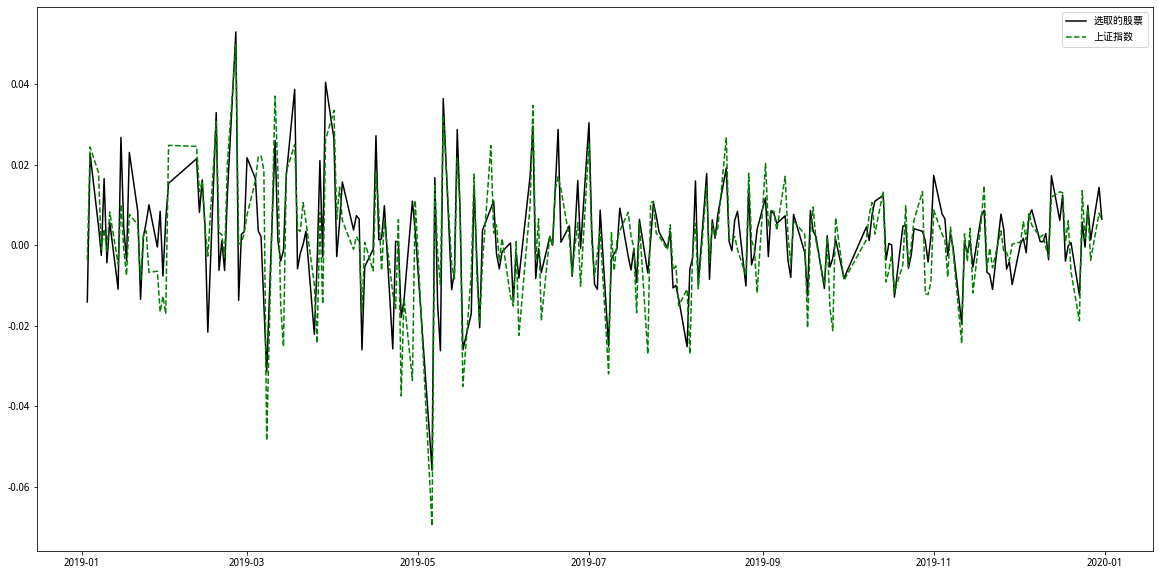

In [54]:
from matplotlib import pyplot as plt
y1=all_close_return_mean['return']
y2=SZ_return_mean['return']
x=SZ_return_mean.index
plt.figure(figsize=(20,10))
plt.plot(x,y1,label="选取的股票",color="#000000")
plt.plot(x,y2,label="上证指数",color="#008000",linestyle="--")
plt.legend()
plt.show()